# SCENIC Analysis of VEN Data

In [258]:
import os
import ast
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=150, color_map='viridis')
sc.logging.print_versions()

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.3 scipy==1.3.1 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1


In [259]:
data_path = "/home/kevin/ven_project"
ven_counts = os.path.join(data_path, "data/L5_VEN/l5_ven_count_table.txt")
auc_mat_path = os.path.join(data_path, "scenic/aucell_output_reg.csv")

# Scanpy Analysis

### Load count data

In [260]:
adata = sc.read_text(ven_counts).T 
adata.shape

(879, 30370)

### Merge AnnData with AUC from SCENIC

In [261]:
auc = pd.read_csv(auc_mat_path, index_col=0).T
auc.shape

# Merge AnnData with AUC
idx = list(adata.obs.index)
idx = [x.replace("~", ".") for x in idx]
adata.obs.index = idx
adata.obs = adata.obs.join(auc)

In [262]:
# Make Donor Observation
idx = list(adata.obs.index)
idx =  [x.split("H200")[1] for x in idx]
idx = [x[1:5] for x in idx]
adata.obs['donor'] = idx

## Preprocessing

In [263]:
## Basic cell filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 4517 genes that are detectedin less than 3 cells


... storing 'donor' as categorical


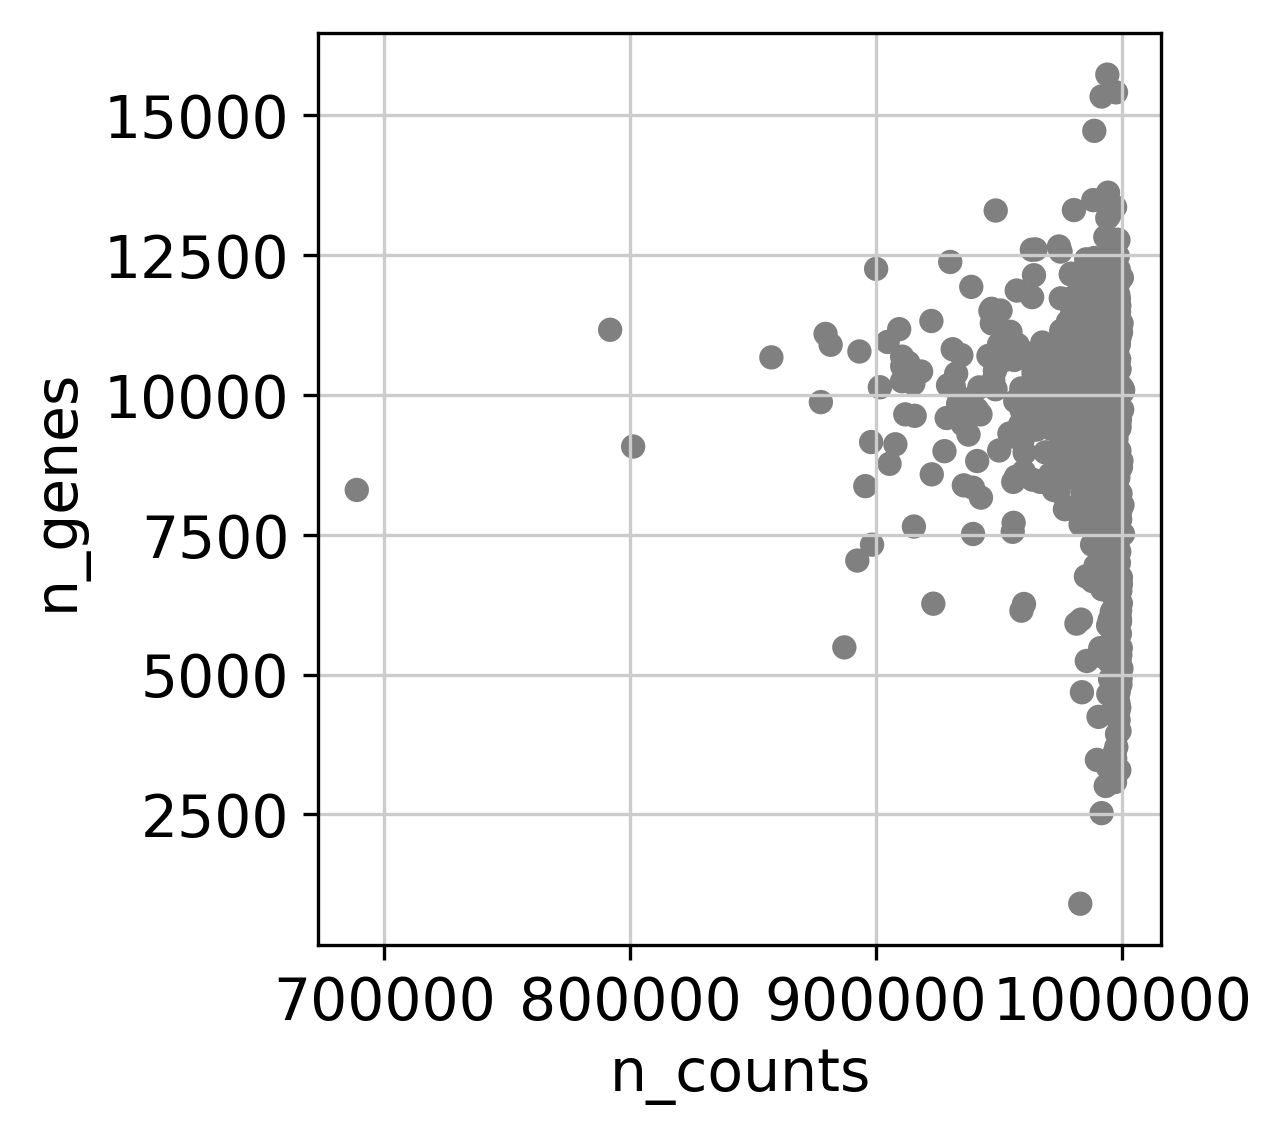

In [264]:
adata.obs['n_counts'] = adata.X.sum(axis=1)
sc.pl.scatter(adata, x="n_counts", y='n_genes')

In [265]:
adata = adata[adata.obs['n_genes'] < 14000, :]
adata = adata[adata.obs['n_counts'] > 900000, :]
adata.shape

(861, 25853)

In [266]:
# Normalization
sc.pp.normalize_total(adata, target_sum=1e4)
# logarithmize
sc.pp.log1p(adata)
adata.raw = adata

Normalizing counts per cell.
    finished (0:00:00):normalized adata.X


/home/kevin/anaconda3/envs/ven/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:285: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


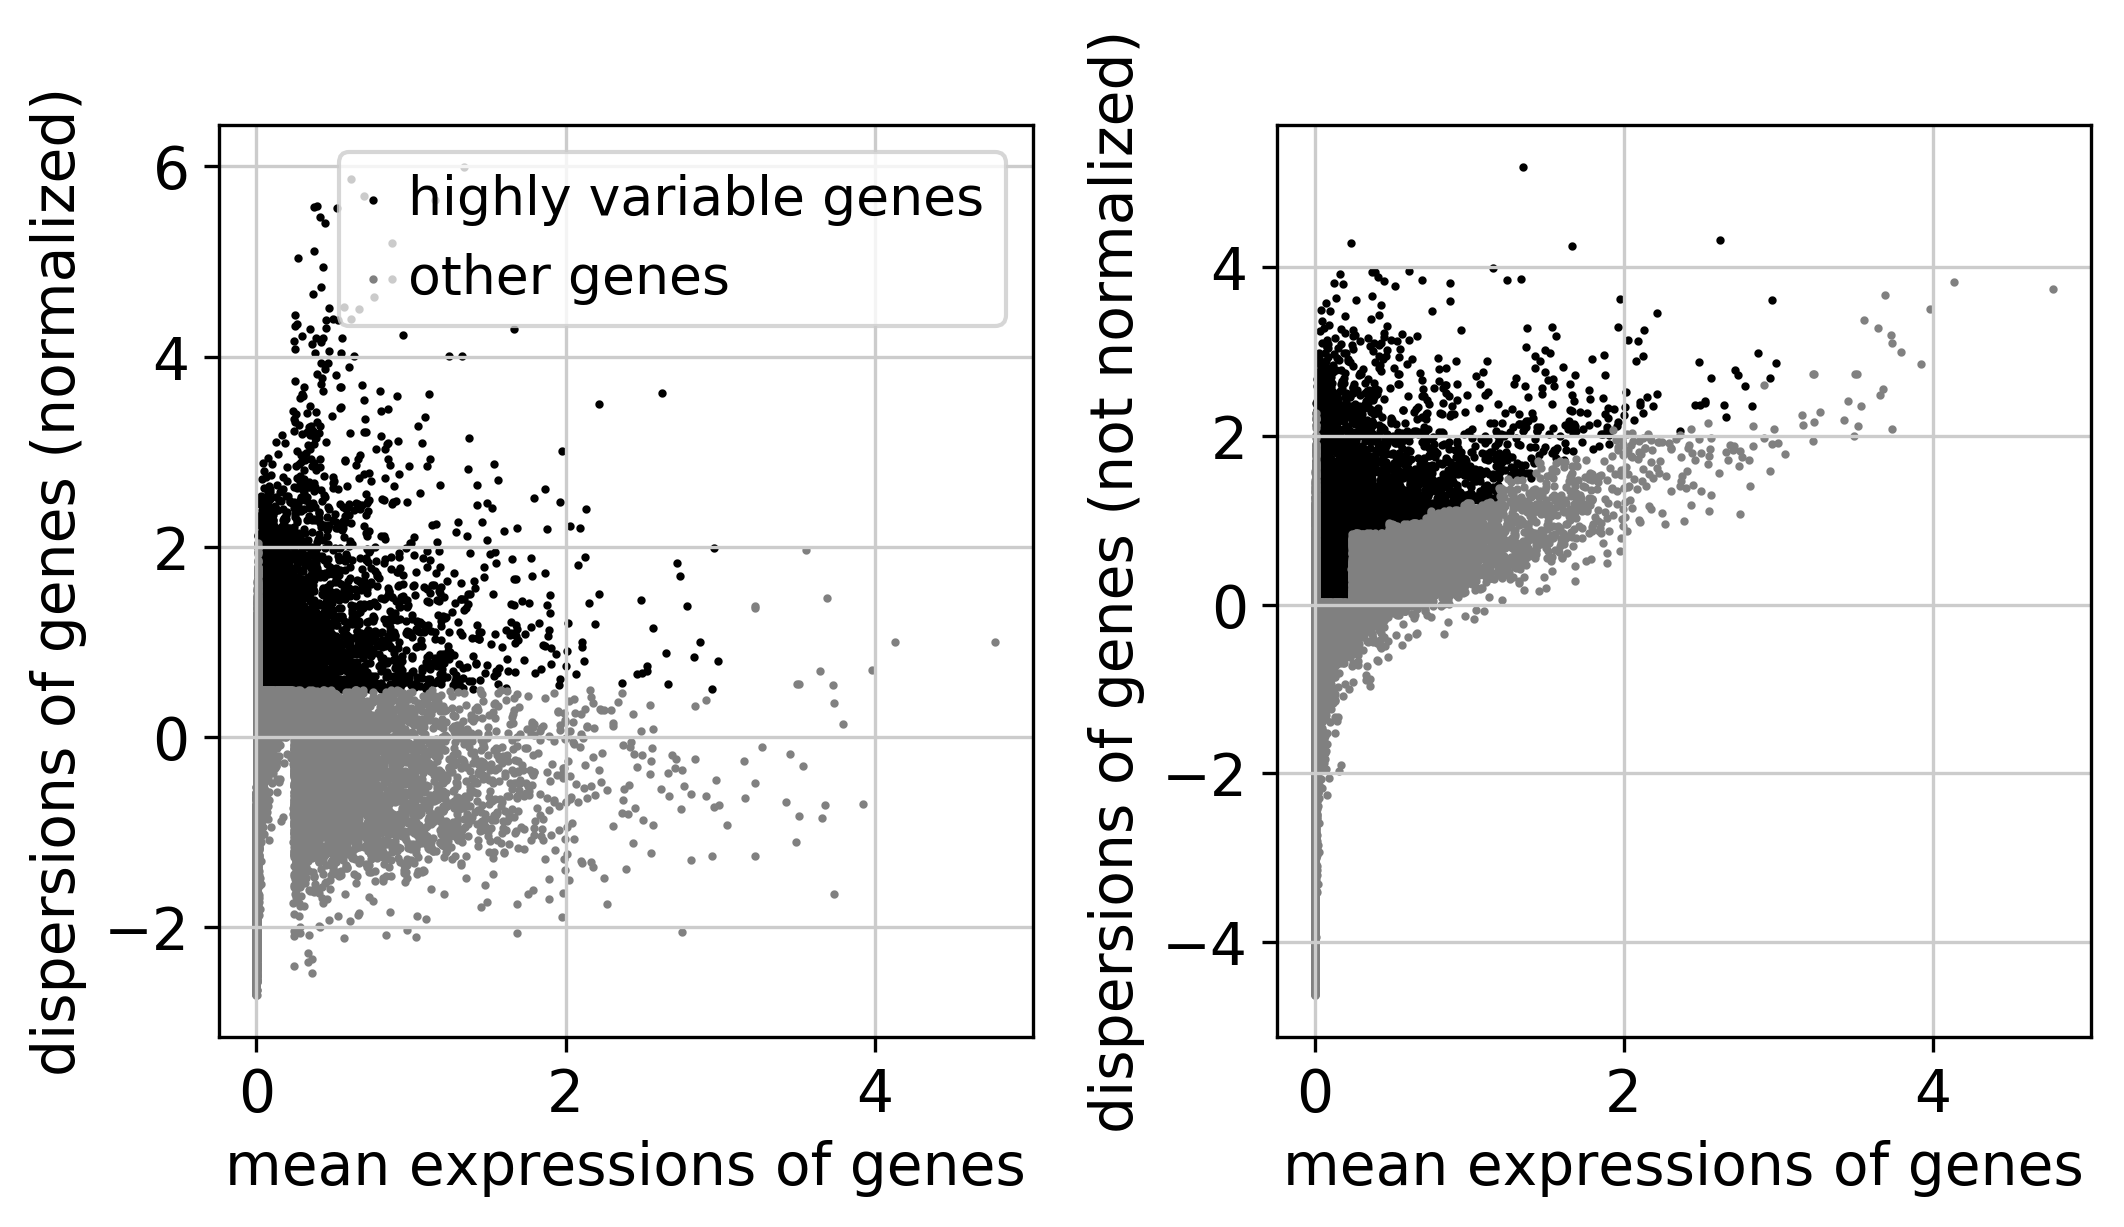

In [267]:
# Highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [268]:
# filter non-variable genes
adata = adata[:, adata.var.highly_variable]
# regress out effects from different numbers of counts
sc.pp.regress_out(adata, ['n_counts'])
# scale each gene to unit variance
sc.pp.scale(adata, max_value=10)

regressing out ['n_counts']
    finished (0:00:19)


## Visualization and clustering

In [269]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


In [270]:
# Clustering
sc.tl.leiden(adata, resolution=0.5)

running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


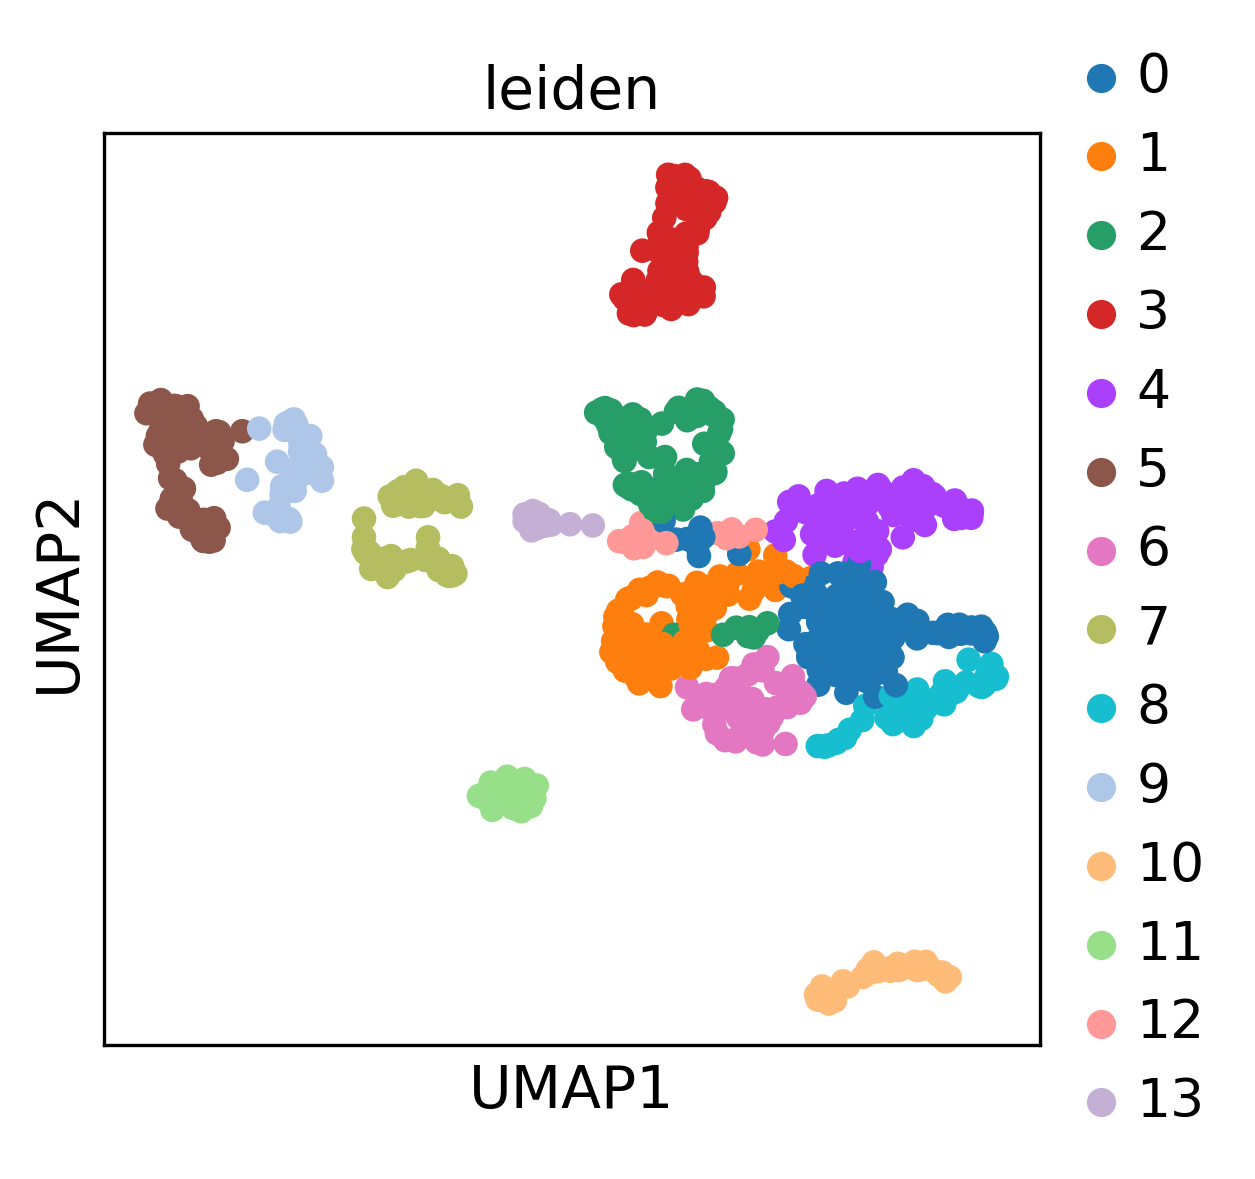

In [271]:
sc.pl.umap(adata, color=['leiden'])

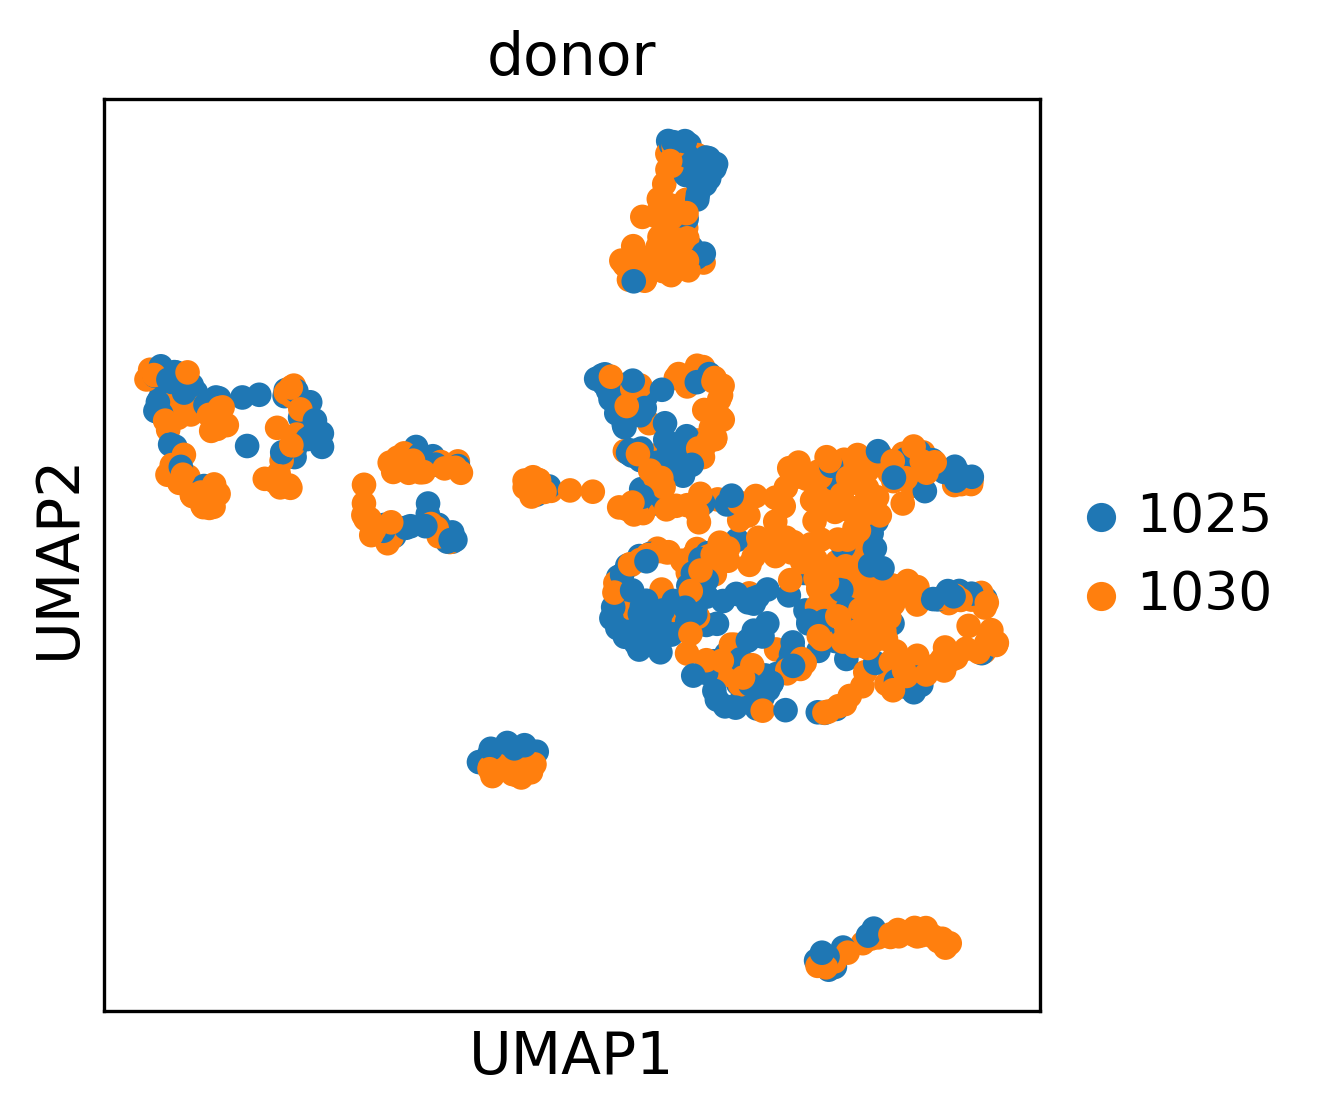

In [272]:
# color by donor
sc.pl.umap(adata, color=['donor'])

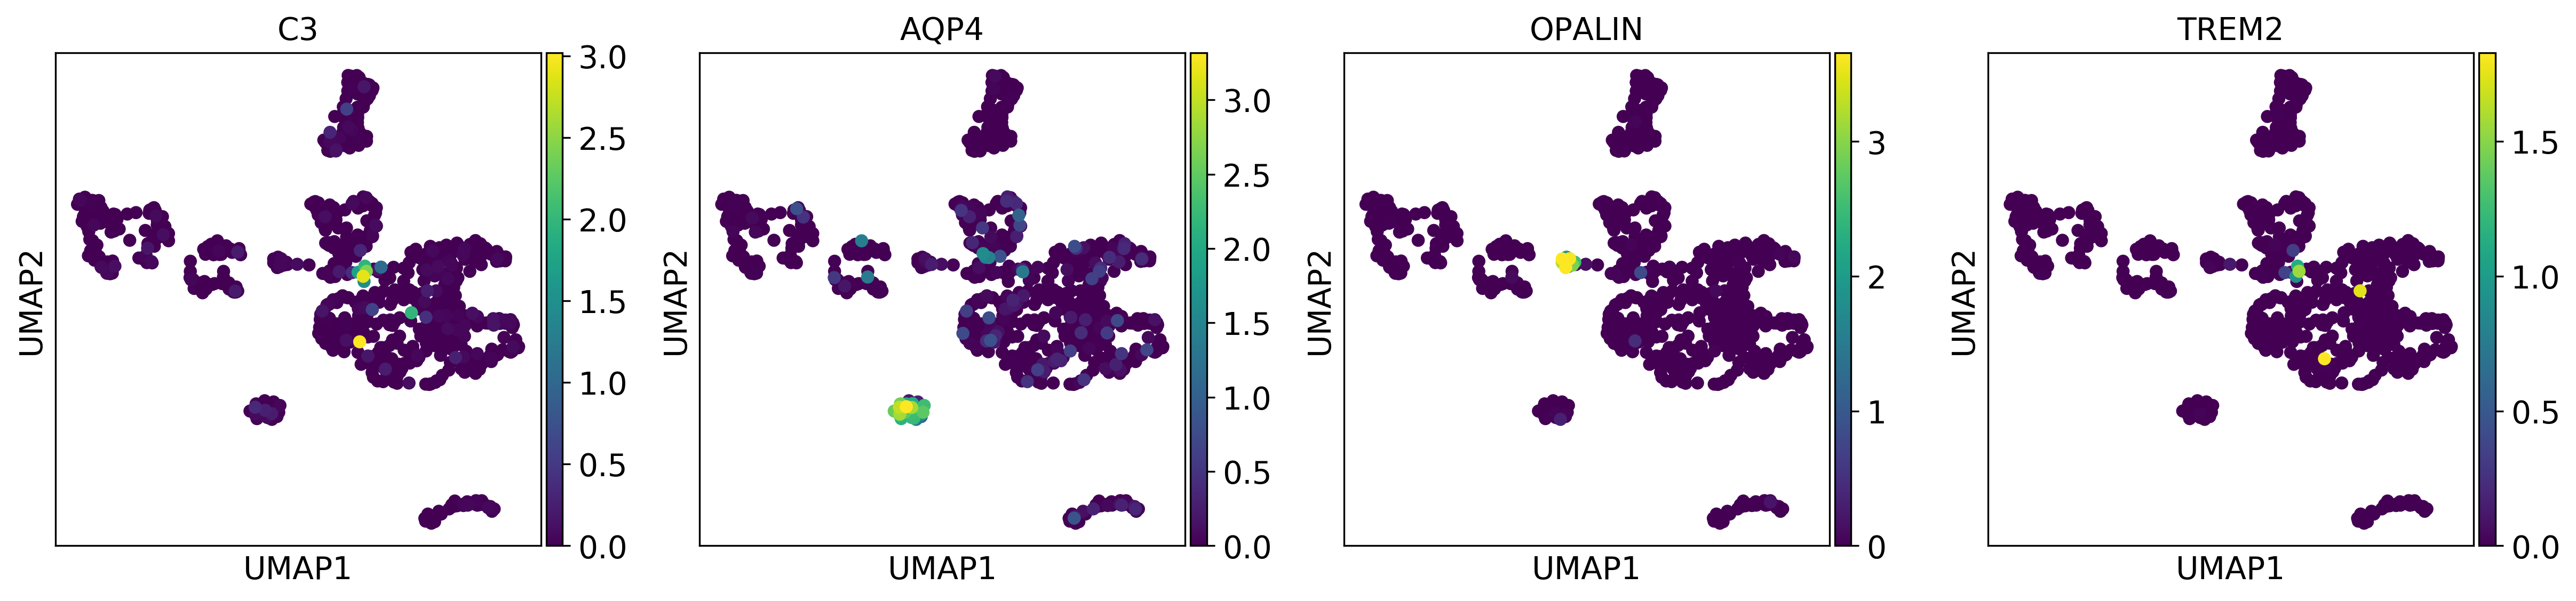

In [273]:
# Non-neuronal
sc.pl.umap(adata, color=['C3', 'AQP4', 'OPALIN', 'TREM2'])

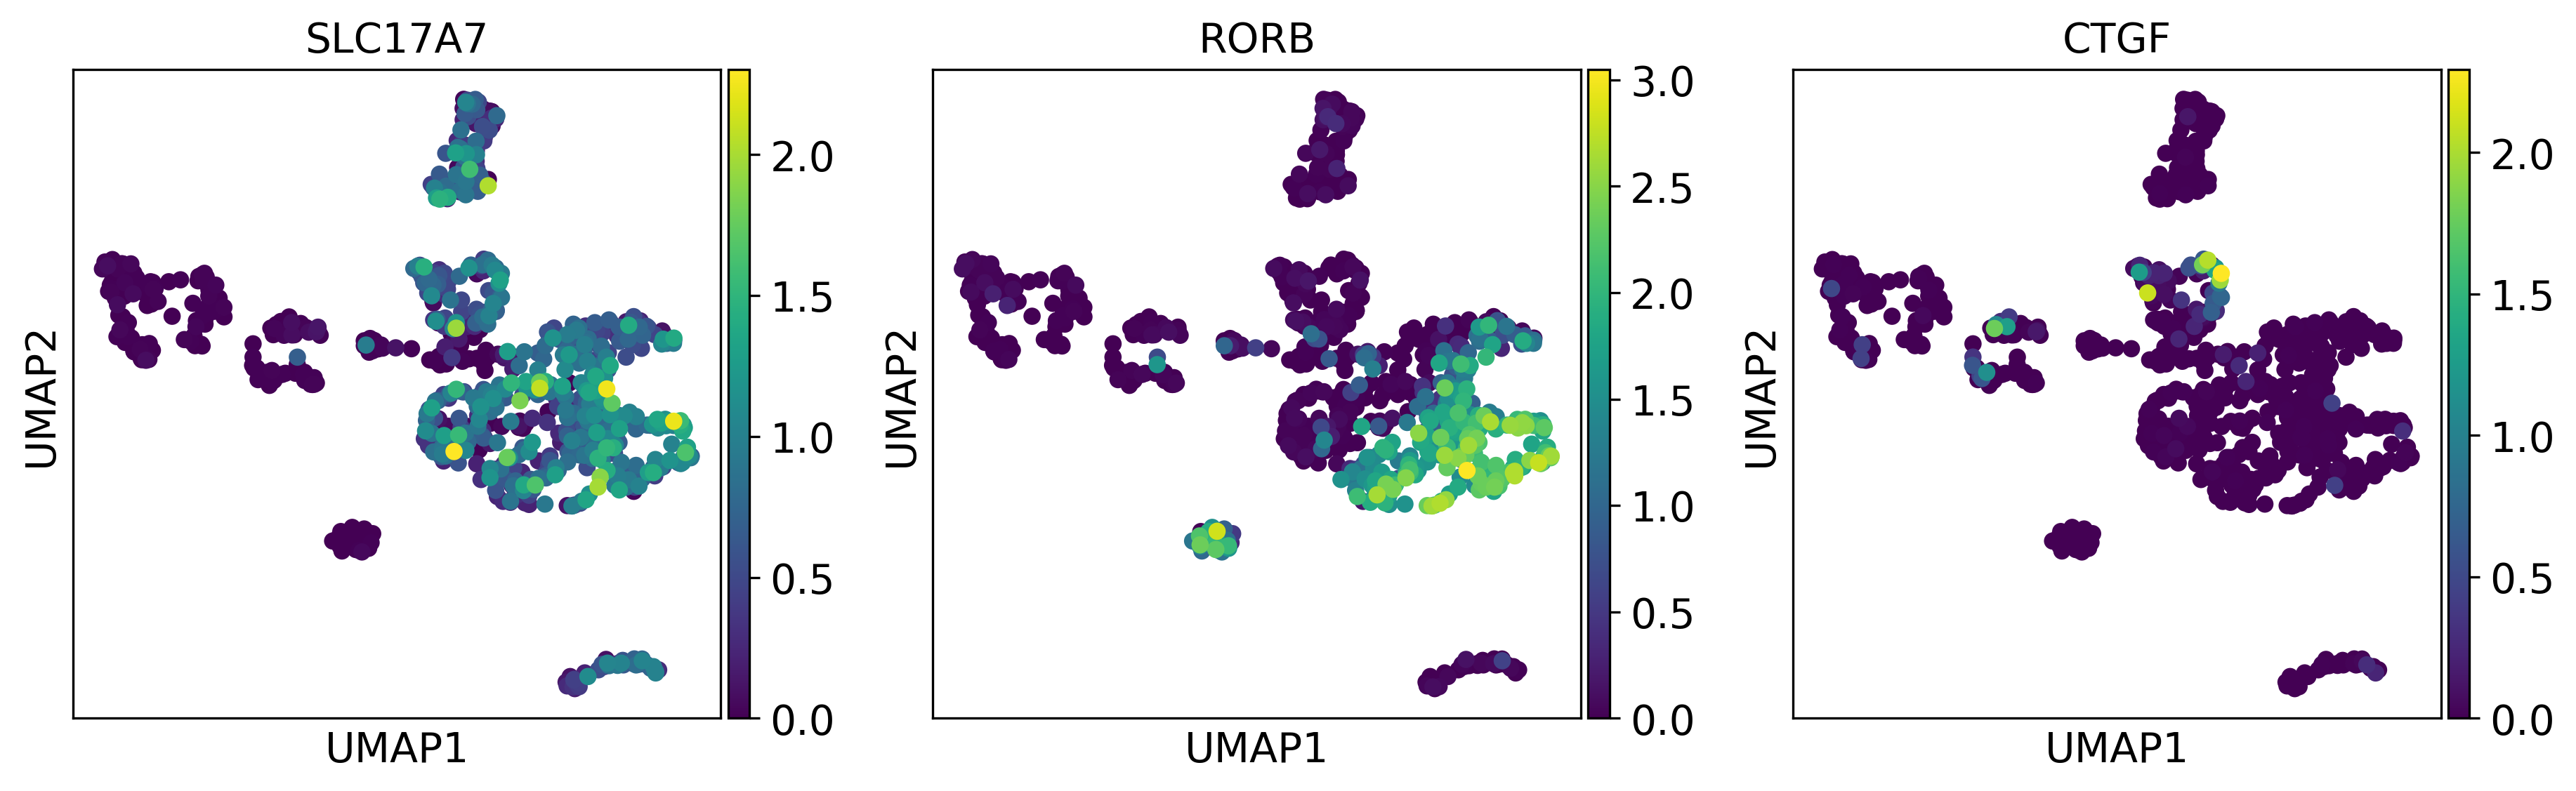

In [274]:
# Excitatory Neurons
sc.pl.umap(adata, color=['SLC17A7', 'RORB', 'CTGF'])

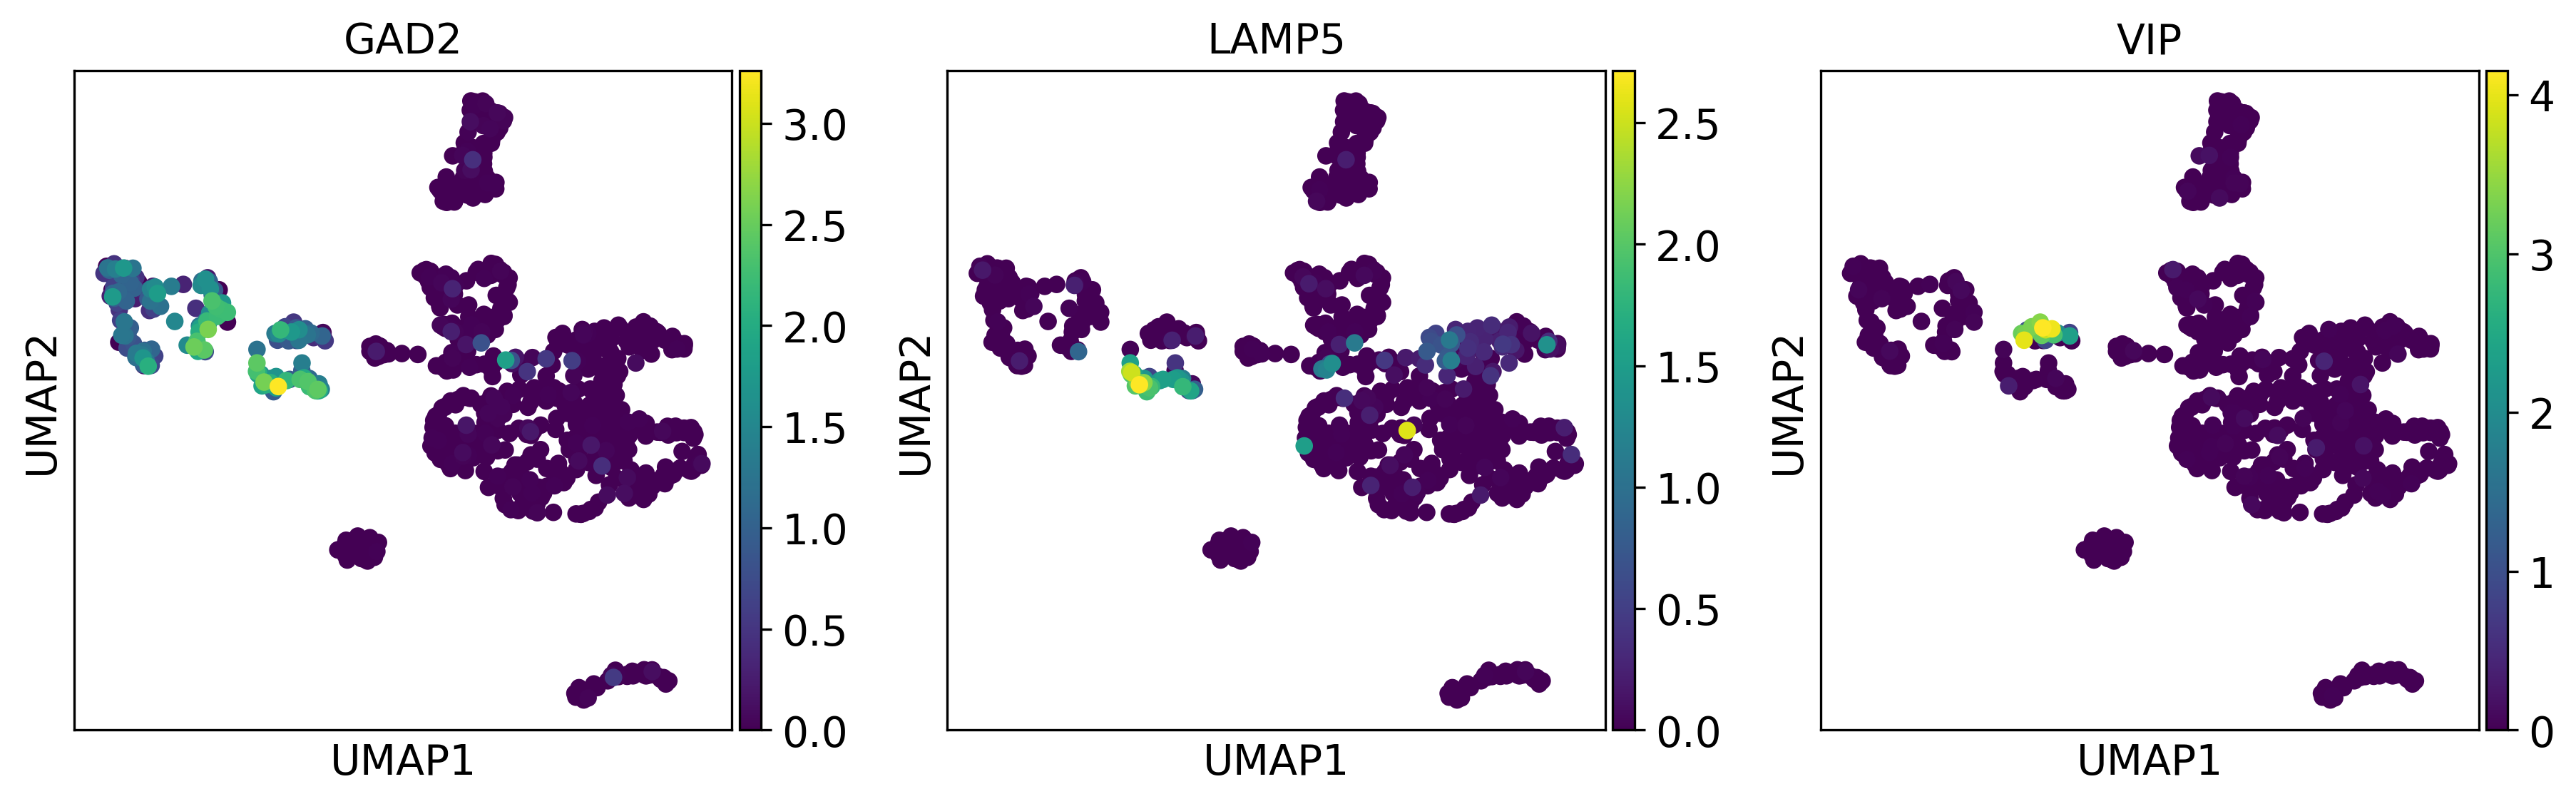

In [275]:
# Inhibitory Neurons
sc.pl.umap(adata, color=['GAD2', 'LAMP5', 'VIP'])

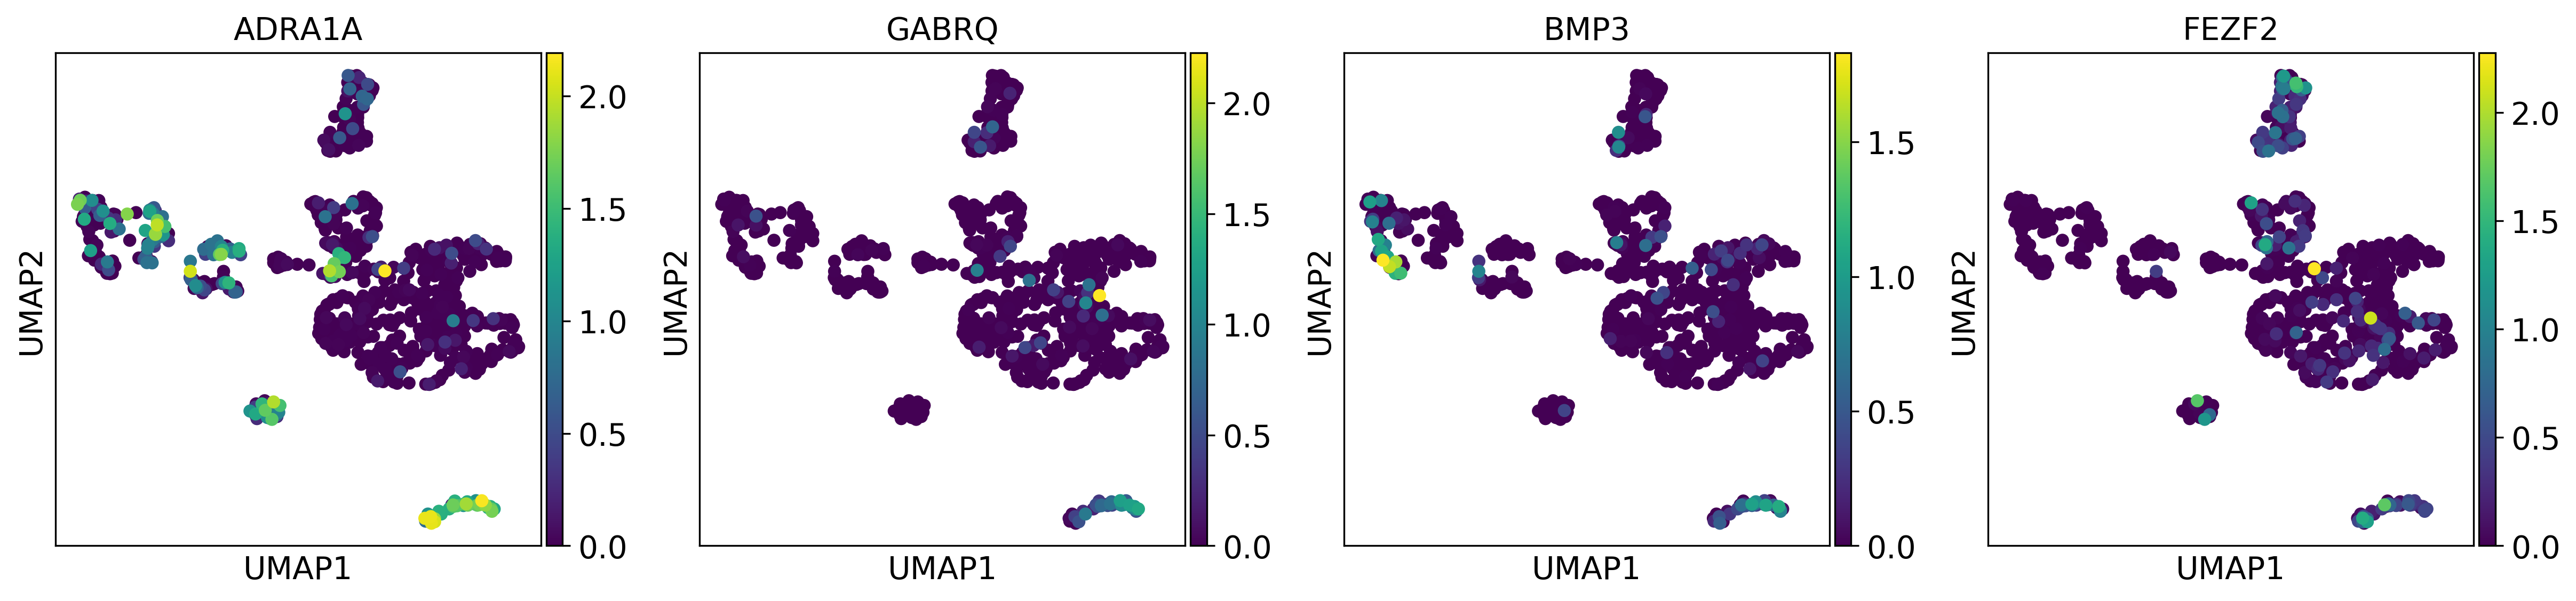

In [276]:
# Van-economo neurons
sc.pl.umap(adata, color=['ADRA1A', 'GABRQ', 'BMP3', 'FEZF2'])

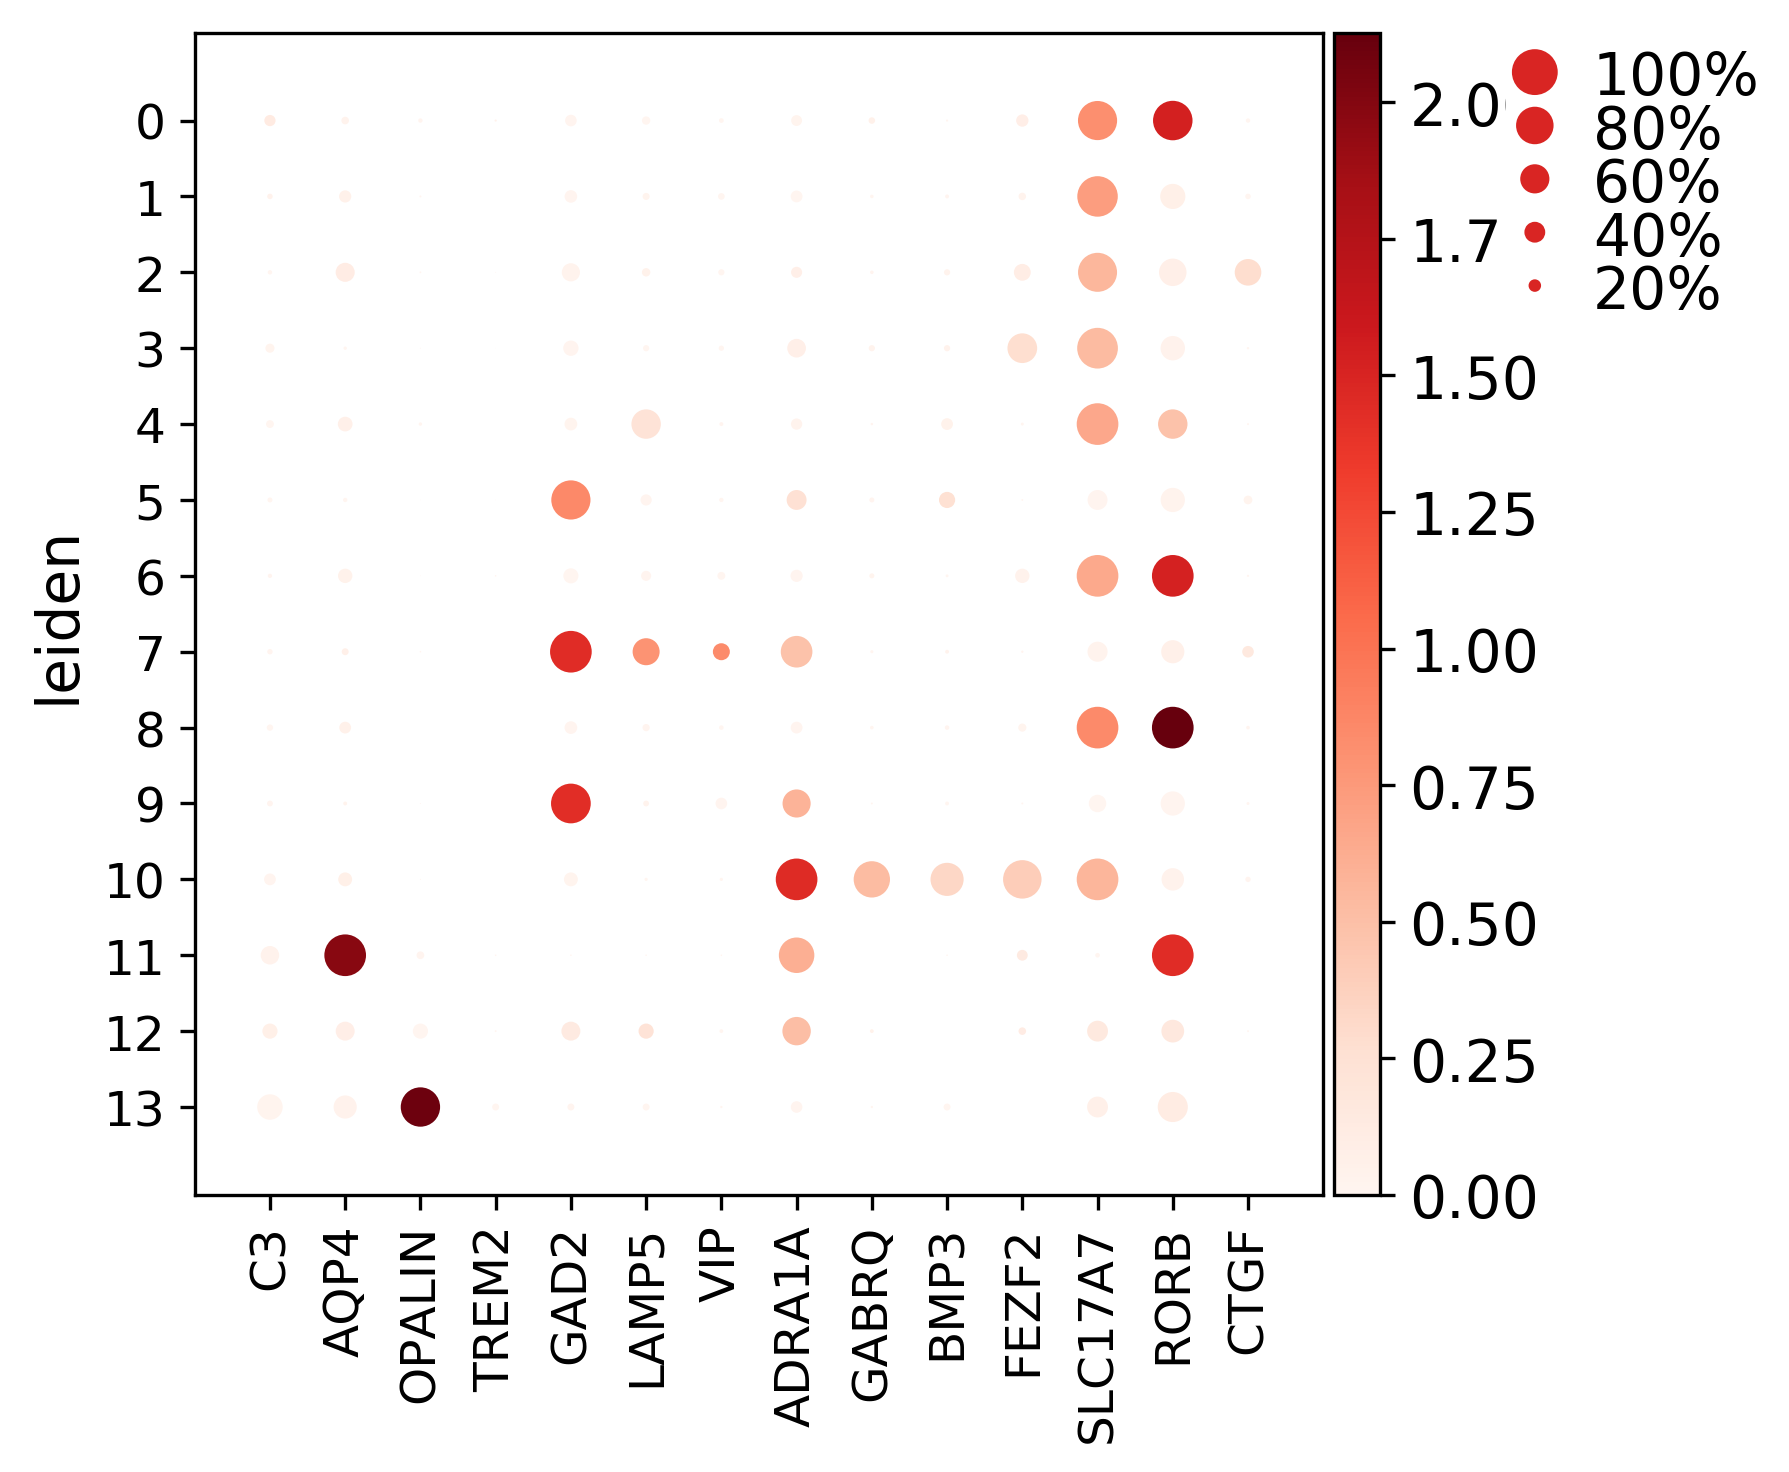

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[4.8999999999999995, 0, 0.2, 0.5, 0.25])

In [277]:
sc.pl.dotplot(adata, var_names=['C3', 'AQP4', 'OPALIN', 'TREM2', 'GAD2', 'LAMP5', 'VIP', 'ADRA1A', 'GABRQ', 'BMP3', 'FEZF2',
                                  'SLC17A7', 'RORB', 'CTGF'],
                 groupby='leiden')

# Regulon analysis

Calculate the average regulon activity score for each cluster and then compare them.

In [278]:
auc_mat = adata.obs.iloc[:,0:358]
auc_mat['cluster'] = adata.obs['leiden']

In [279]:
auc_avg = auc_mat.groupby('cluster').mean()
colnames = auc_avg.columns
colnames = [x.replace("(+)", "") for x in colnames]
colnames = [x.replace("(-)", "") for x in colnames]
auc_avg.columns = colnames

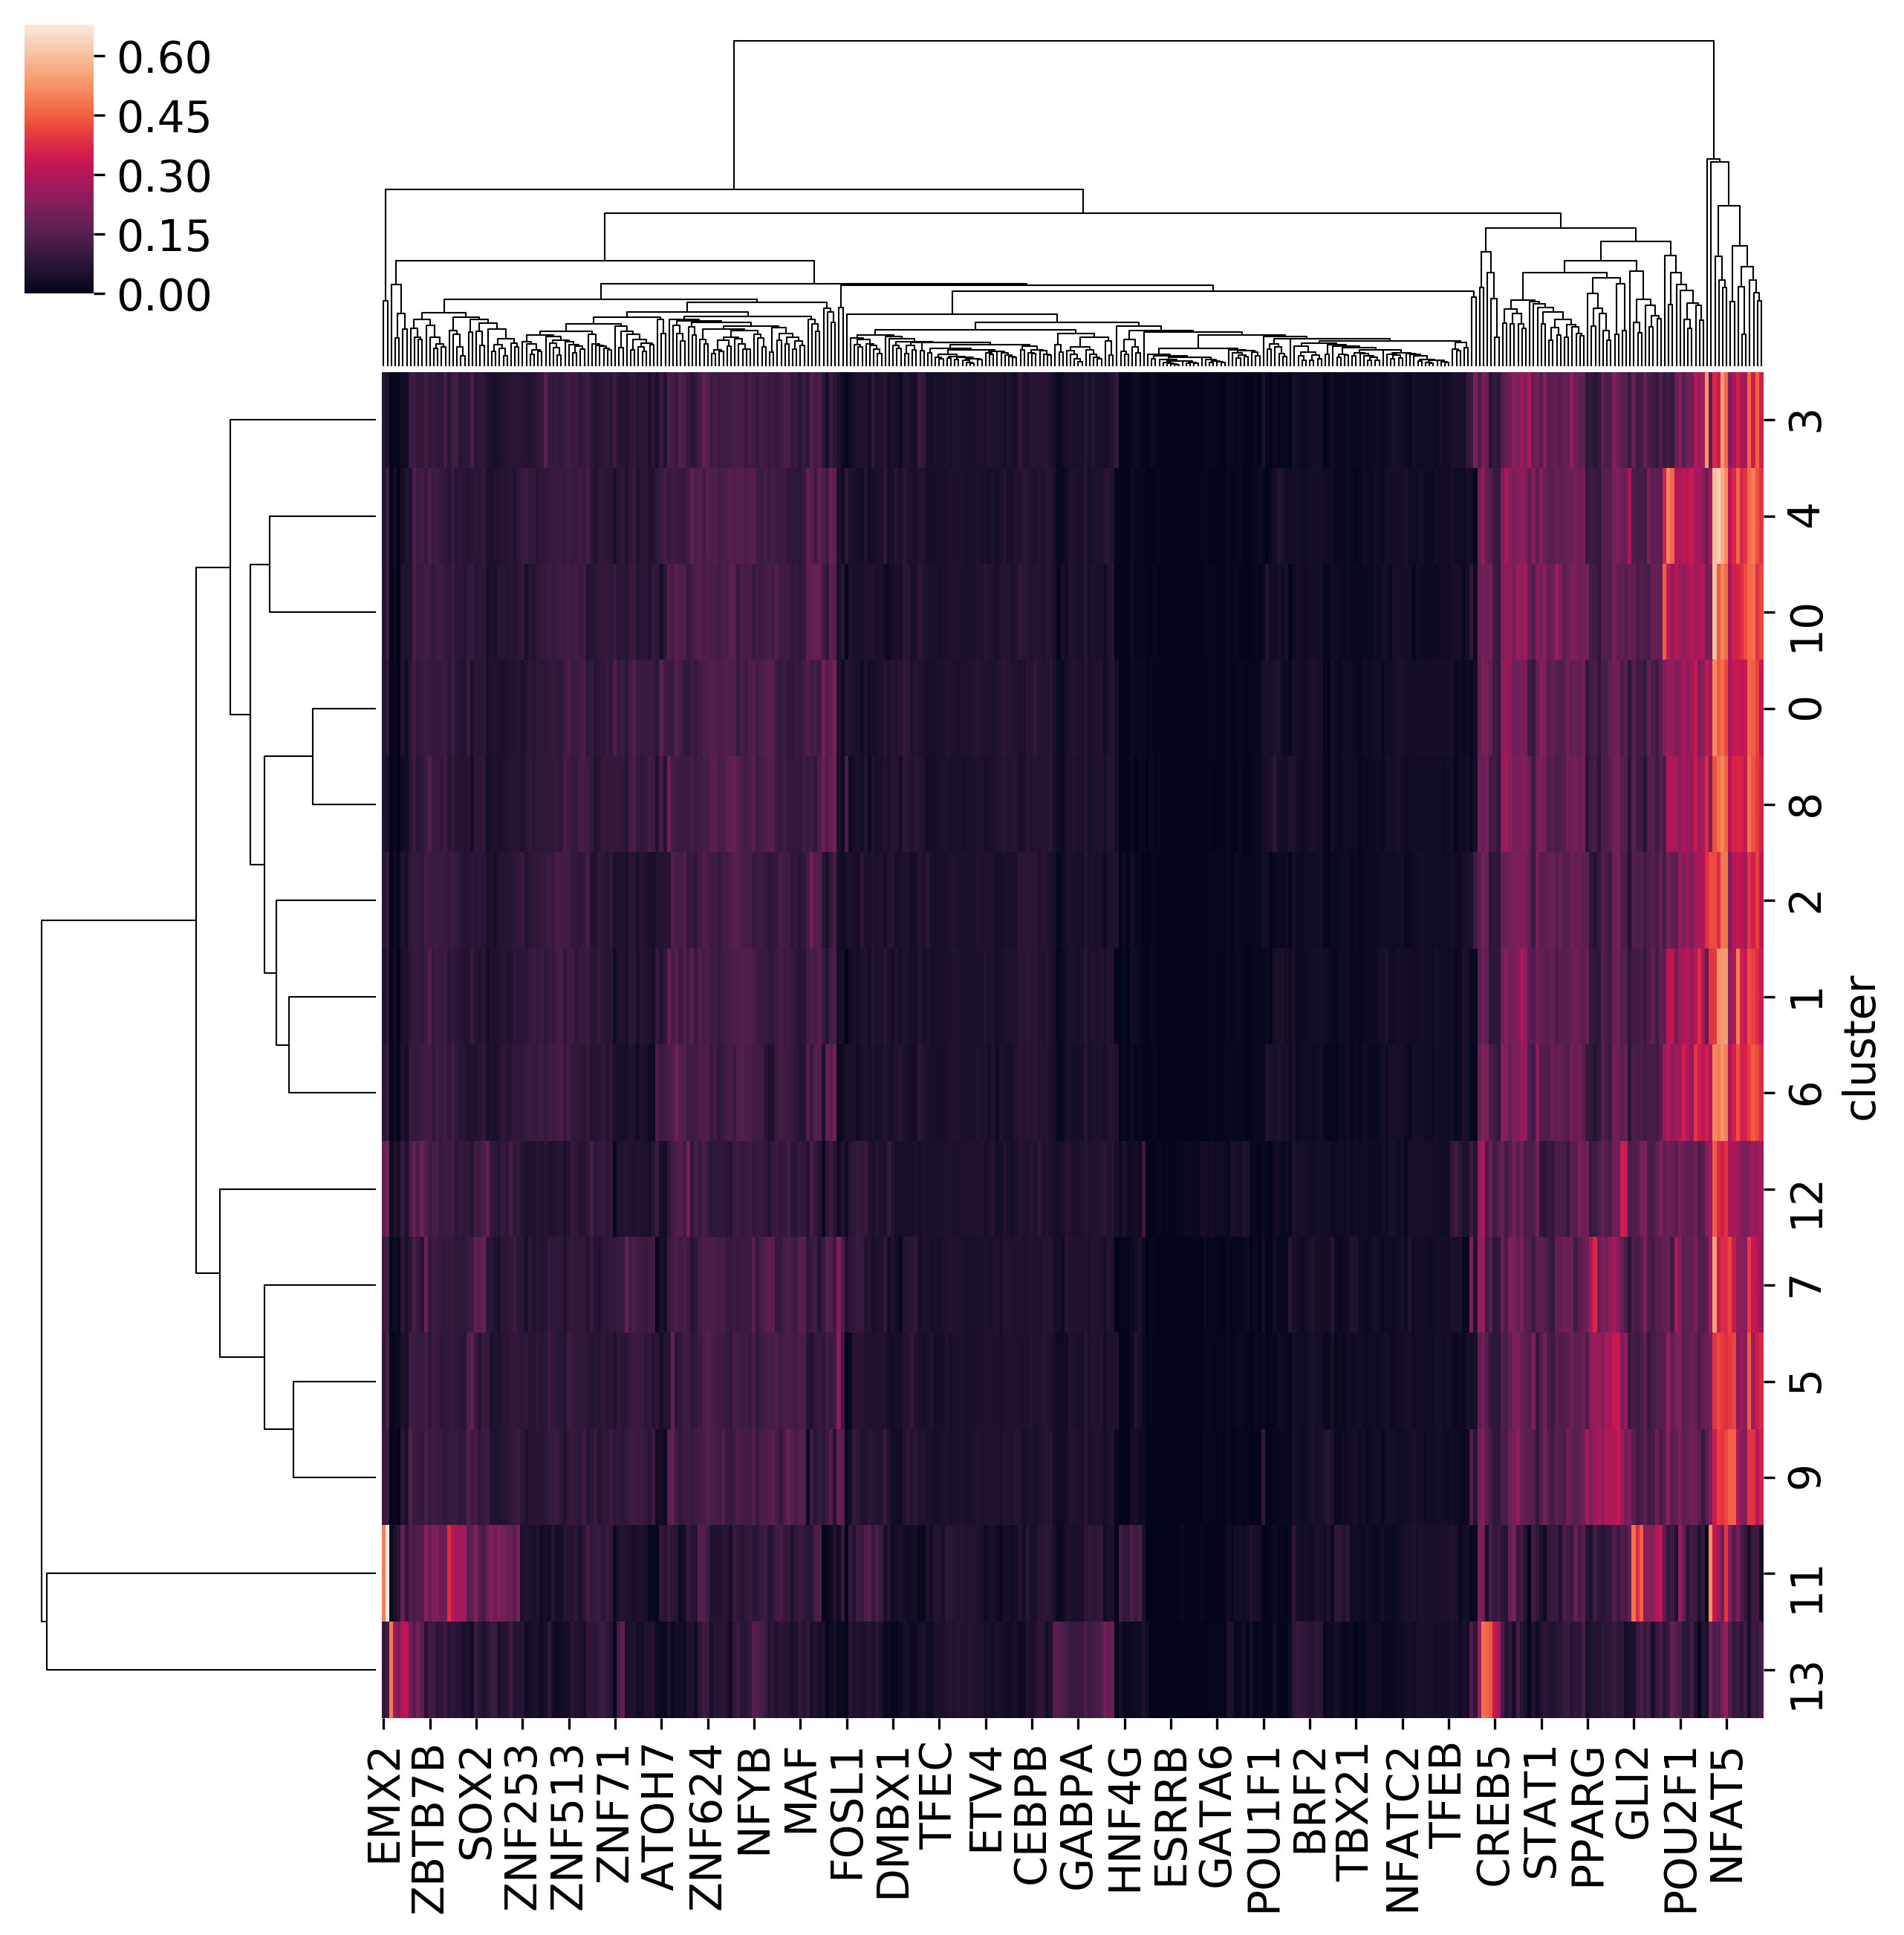

In [280]:
sns.clustermap(auc_avg)

## Find Regulons with FTD genes

In [281]:
grn = pd.read_csv(os.path.join(data_path, "scenic", "ctx_output_reg.csv"))
grn.drop([0,1], inplace=True)
grn.drop(columns=['Unnamed: 1','Enrichment','Enrichment.1','Enrichment.2','Enrichment.3'
                  ,'Enrichment.4','Enrichment.5','Enrichment.6'], axis=1, inplace=True)
grn.columns = ['TF', 'Targets']
grn.head()

,TF,Targets
2,ARID3A,"[('PLXDC2', 1.4195250523137166), ('LINC00940',..."
3,ATF2,"[('FBXO3', 0.4891237213845977), ('ZNF706', 2.2..."
4,ATF2,"[('MIR22', 0.4891237213845977), ('ZNF706', 2.2..."
5,ATF2,"[('FBXO3', 0.4891237213845977), ('ZNF706', 2.2..."
6,ATF2,"[('FBXO3', 0.4891237213845977), ('SLC12A5', 2...."


In [282]:
def convert_targets(targets):
    """Evaluate string and make list of target genes"""
    targets = ast.literal_eval(targets)
    targets = [x[0] for x in targets]
    return targets


In [283]:
target_list = list(grn['Targets'])
for i in range(grn.shape[0]):
    if i % 500 == 0:
        print(i)
    targets = target_list[i]
    targets = convert_targets(targets)
    grn.iloc[i,1] = targets

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


In [284]:
# append target lists for each TF
grn = grn.groupby('TF').agg(sum)
# get rid of duplicates
target_list = grn['Targets']
for i in range(grn.shape[0]):
    grn.iloc[i,0] = list(set(target_list[i]))

grn.head()

,Targets
TF,
ALX1,"[OTX2-AS1, ISL1, LEF1-AS1, SLC4A1, ADGRE1, ANT..."
ARID3A,"[RAB40B, REXO1, PHLDB2, SPNS2, C1QTNF8, RENBP,..."
ARX,"[SLAMF8, NPAS1, SIAH3, RGPD1, KIAA0141, SAMD13..."
ASCL2,"[PLSCR5, PHLDB2, CNTN5, SCN7A, PCED1B, CRB3, C..."
ATF1,"[KMT2A, HDGF, SYT7, KNDC1, GDNF-AS1, DNMT3A, S..."


### Look for regulons with FTD mendelian genes

In [294]:
ftd = pd.read_csv(os.path.join(data_path, "data/genes", "FTD_gene_list.txt"), sep="\t", header=None)
ftd = set(ftd.iloc[:,0])
ftd

{'ADNP',
 'ALS2',
 'ANG',
 'APOE',
 'APP',
 'ARHGEF28',
 'ARSA',
 'ATXN1',
 'ATXN2',
 'ATXN2-AS',
 'BDNF',
 'BTNL2',
 'C21orf2',
 'C9orf72',
 'CCNF',
 'CHCHD10',
 'CHGB',
 'CHMP2B',
 'CHRNA3',
 'CHRNA4',
 'CHRNB4',
 'CLN5',
 'CSF1R',
 'CTSC',
 'CTSD',
 'CTSF',
 'CX3CR1',
 'CYLD',
 'CYP27A1',
 'DAO',
 'DCTN1',
 'DPP6',
 'DPYSL3',
 'ELP3',
 'EPHA3',
 'EPHA4',
 'ERBB4',
 'ERLIN2',
 'EWSR1',
 'FGGY',
 'FIG4',
 'FLNC',
 'FUS',
 'GBA',
 'GLE1',
 'GRN',
 'HEXA',
 'HEXB',
 'HFE',
 'HLA-DRA',
 'HLA-DRB5',
 'HNRNPA1',
 'HNRNPA2B1',
 'IL10',
 'ITM2B',
 'ITPR2',
 'KCNN1',
 'KIF17',
 'KIFAP3',
 'LMNB1',
 'MAOB',
 'MAPT',
 'MATR3',
 'MOBP',
 'NEFH',
 'NEK1',
 'NOTCH3',
 'NPC1',
 'NPC2',
 'OPTN',
 'PFN1',
 'PNPLA6',
 'POLDIP2',
 'PON1',
 'PON2',
 'PON3',
 'PPARGC1A',
 'PRKAR1B',
 'PRNP',
 'PRPH',
 'PRPH2',
 'PSEN1',
 'PSEN2',
 'RAB38',
 'RPSA',
 'SARM1',
 'SCFD1',
 'SETX',
 'SIGMAR1',
 'SMN1',
 'SOD1',
 'SORT1',
 'SPAST',
 'SPG11',
 'SPG20',
 'SPTLC1',
 'SQSTM1',
 'SUPT4H1',
 'TAF15',
 'TARDBP',
 'TB

In [295]:
# get regulons that overlap with FTD genes
ftd_regs = []
ftd_reg_overlap = []
for i in range(grn.shape[0]):
    targets = grn.iloc[i,0]
    res = set(targets).intersection(ftd)
    if len(res) > 0:
        ftd_reg_overlap.append(res)
        ftd_regs.append(grn.index[i])

In [296]:
auc_reg = auc_avg[ftd_regs]

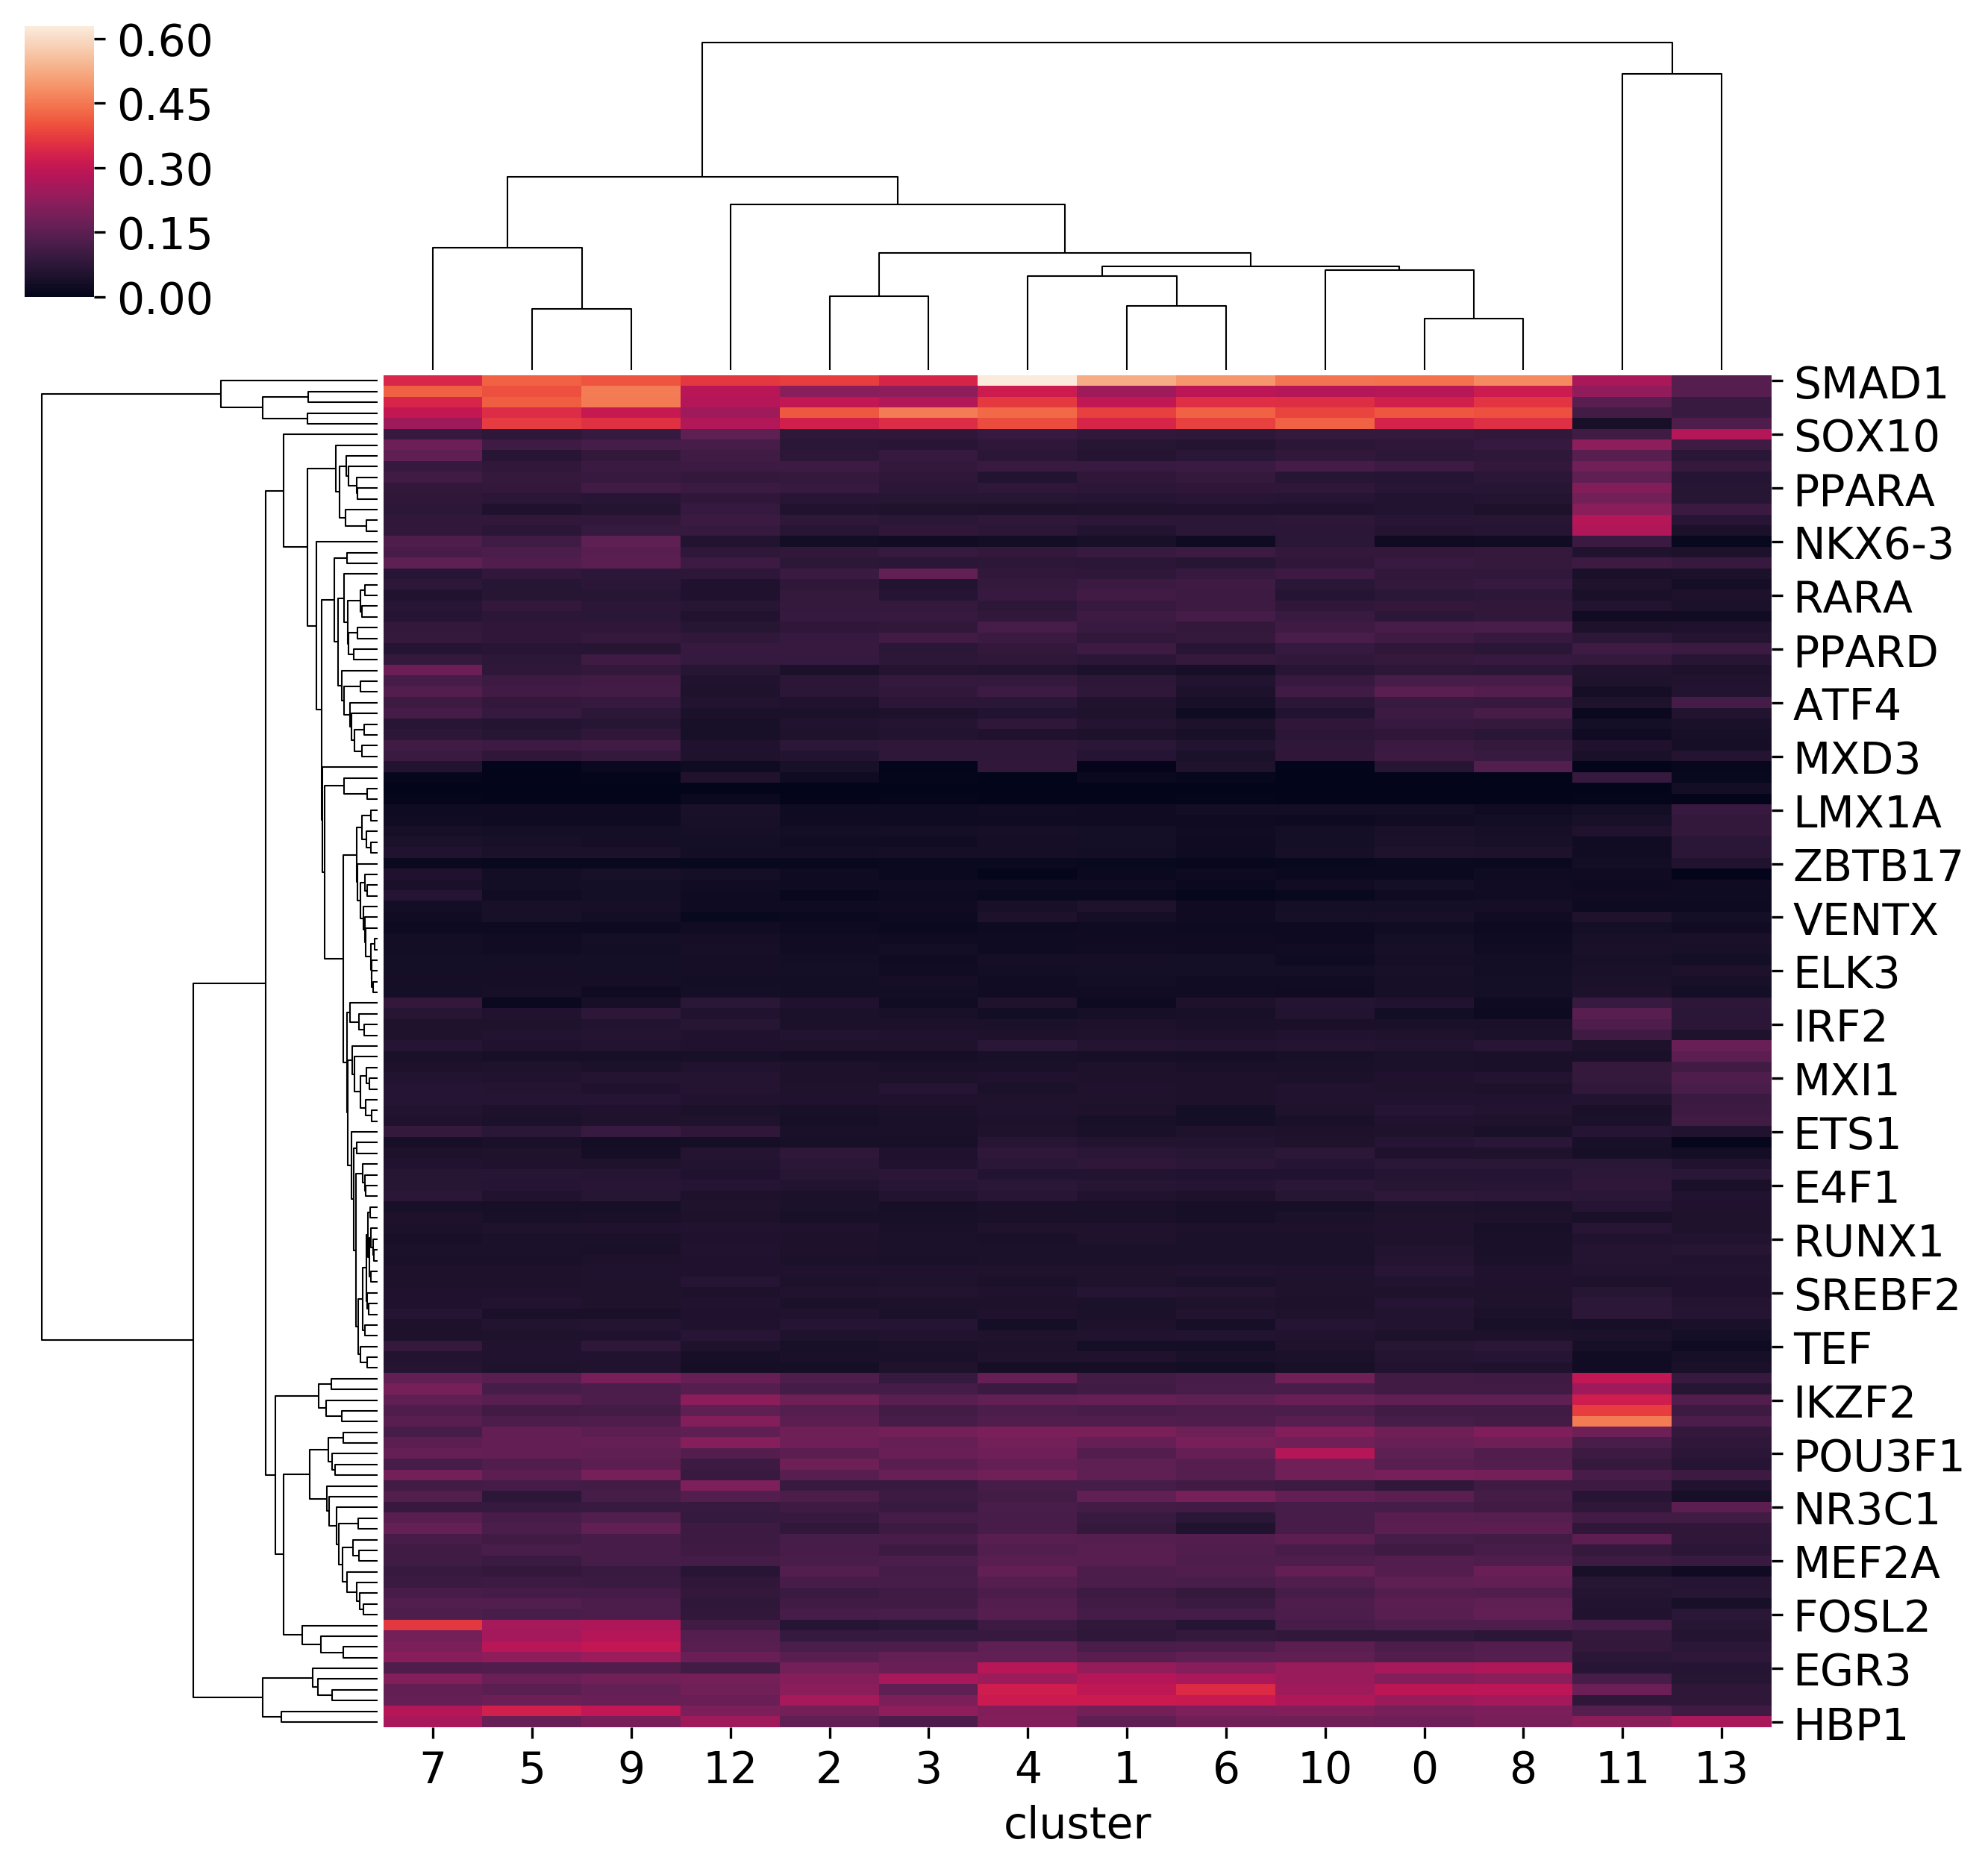

In [297]:
sns.clustermap(auc_reg.T)

In [298]:
auc_reg

,ARID3A,ARX,ATF2,ATF3,ATF4,ATF6B,BACH1,BCL11A,BCL6,BRF2,...,YY1,ZBTB17,ZBTB40,ZEB1,ZMAT4,ZNF16,ZNF250,ZNF263,ZNF274,ZNF76
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.085456,0.082871,0.136481,0.062387,0.094308,0.043060,0.190148,0.407506,0.109483,0.044613,...,0.051160,0.018137,0.031743,0.167314,0.324658,0.149181,0.191387,0.050261,0.081998,0.048811
1,0.091815,0.077656,0.099952,0.048118,0.055437,0.032009,0.185617,0.377132,0.111552,0.033203,...,0.053306,0.013951,0.038656,0.165673,0.297369,0.157540,0.156142,0.041907,0.117656,0.055269
2,0.087234,0.090890,0.096276,0.041333,0.052662,0.030937,0.188238,0.408136,0.129906,0.028105,...,0.050858,0.014097,0.045255,0.178727,0.301111,0.125727,0.143597,0.041082,0.095125,0.051570
3,0.086737,0.089568,0.107983,0.045490,0.071535,0.032121,0.228135,0.455022,0.090698,0.029082,...,0.061679,0.016684,0.039576,0.166544,0.275568,0.101366,0.169112,0.041727,0.095172,0.056508
4,0.073872,0.091098,0.126534,0.053449,0.068972,0.038115,0.204934,0.430448,0.165134,0.036116,...,0.045286,0.015055,0.030263,0.186418,0.370114,0.111440,0.183387,0.043721,0.120220,0.050002
5,0.085504,0.257551,0.113098,0.048920,0.084387,0.033565,0.327678,0.350019,0.143501,0.040167,...,0.060630,0.014190,0.054813,0.160834,0.415610,0.075276,0.152007,0.039509,0.113521,0.051344
6,0.100381,0.086814,0.088329,0.032734,0.039654,0.027326,0.200973,0.421227,0.118640,0.024908,...,0.048562,0.010782,0.040288,0.192639,0.355137,0.190371,0.139703,0.038314,0.110251,0.056665
7,0.068214,0.185420,0.118110,0.058025,0.100577,0.037544,0.279144,0.299873,0.157802,0.046066,...,0.063259,0.017814,0.064795,0.150101,0.338648,0.135063,0.186704,0.048268,0.112330,0.048428
8,0.083436,0.072786,0.131878,0.057298,0.092646,0.038315,0.194161,0.399892,0.104215,0.040720,...,0.048161,0.019119,0.020639,0.176492,0.361295,0.114049,0.187799,0.048368,0.104635,0.047631


In [304]:
test = list(auc_reg.iloc[:,0])
test.index(max(test))

6

In [310]:
max_list = []
min_list = []
for i in range(auc_avg.shape[1]):
    tf = auc_avg.columns[i]
    tmp = list(auc_avg.iloc[:,i])
    idx = tmp.index(max(tmp))
    idx_low = tmp.index(min(tmp))
    if idx == 10:
        max_list.append(tf)
    elif idx_low == 10:
        min_list.append(tf)

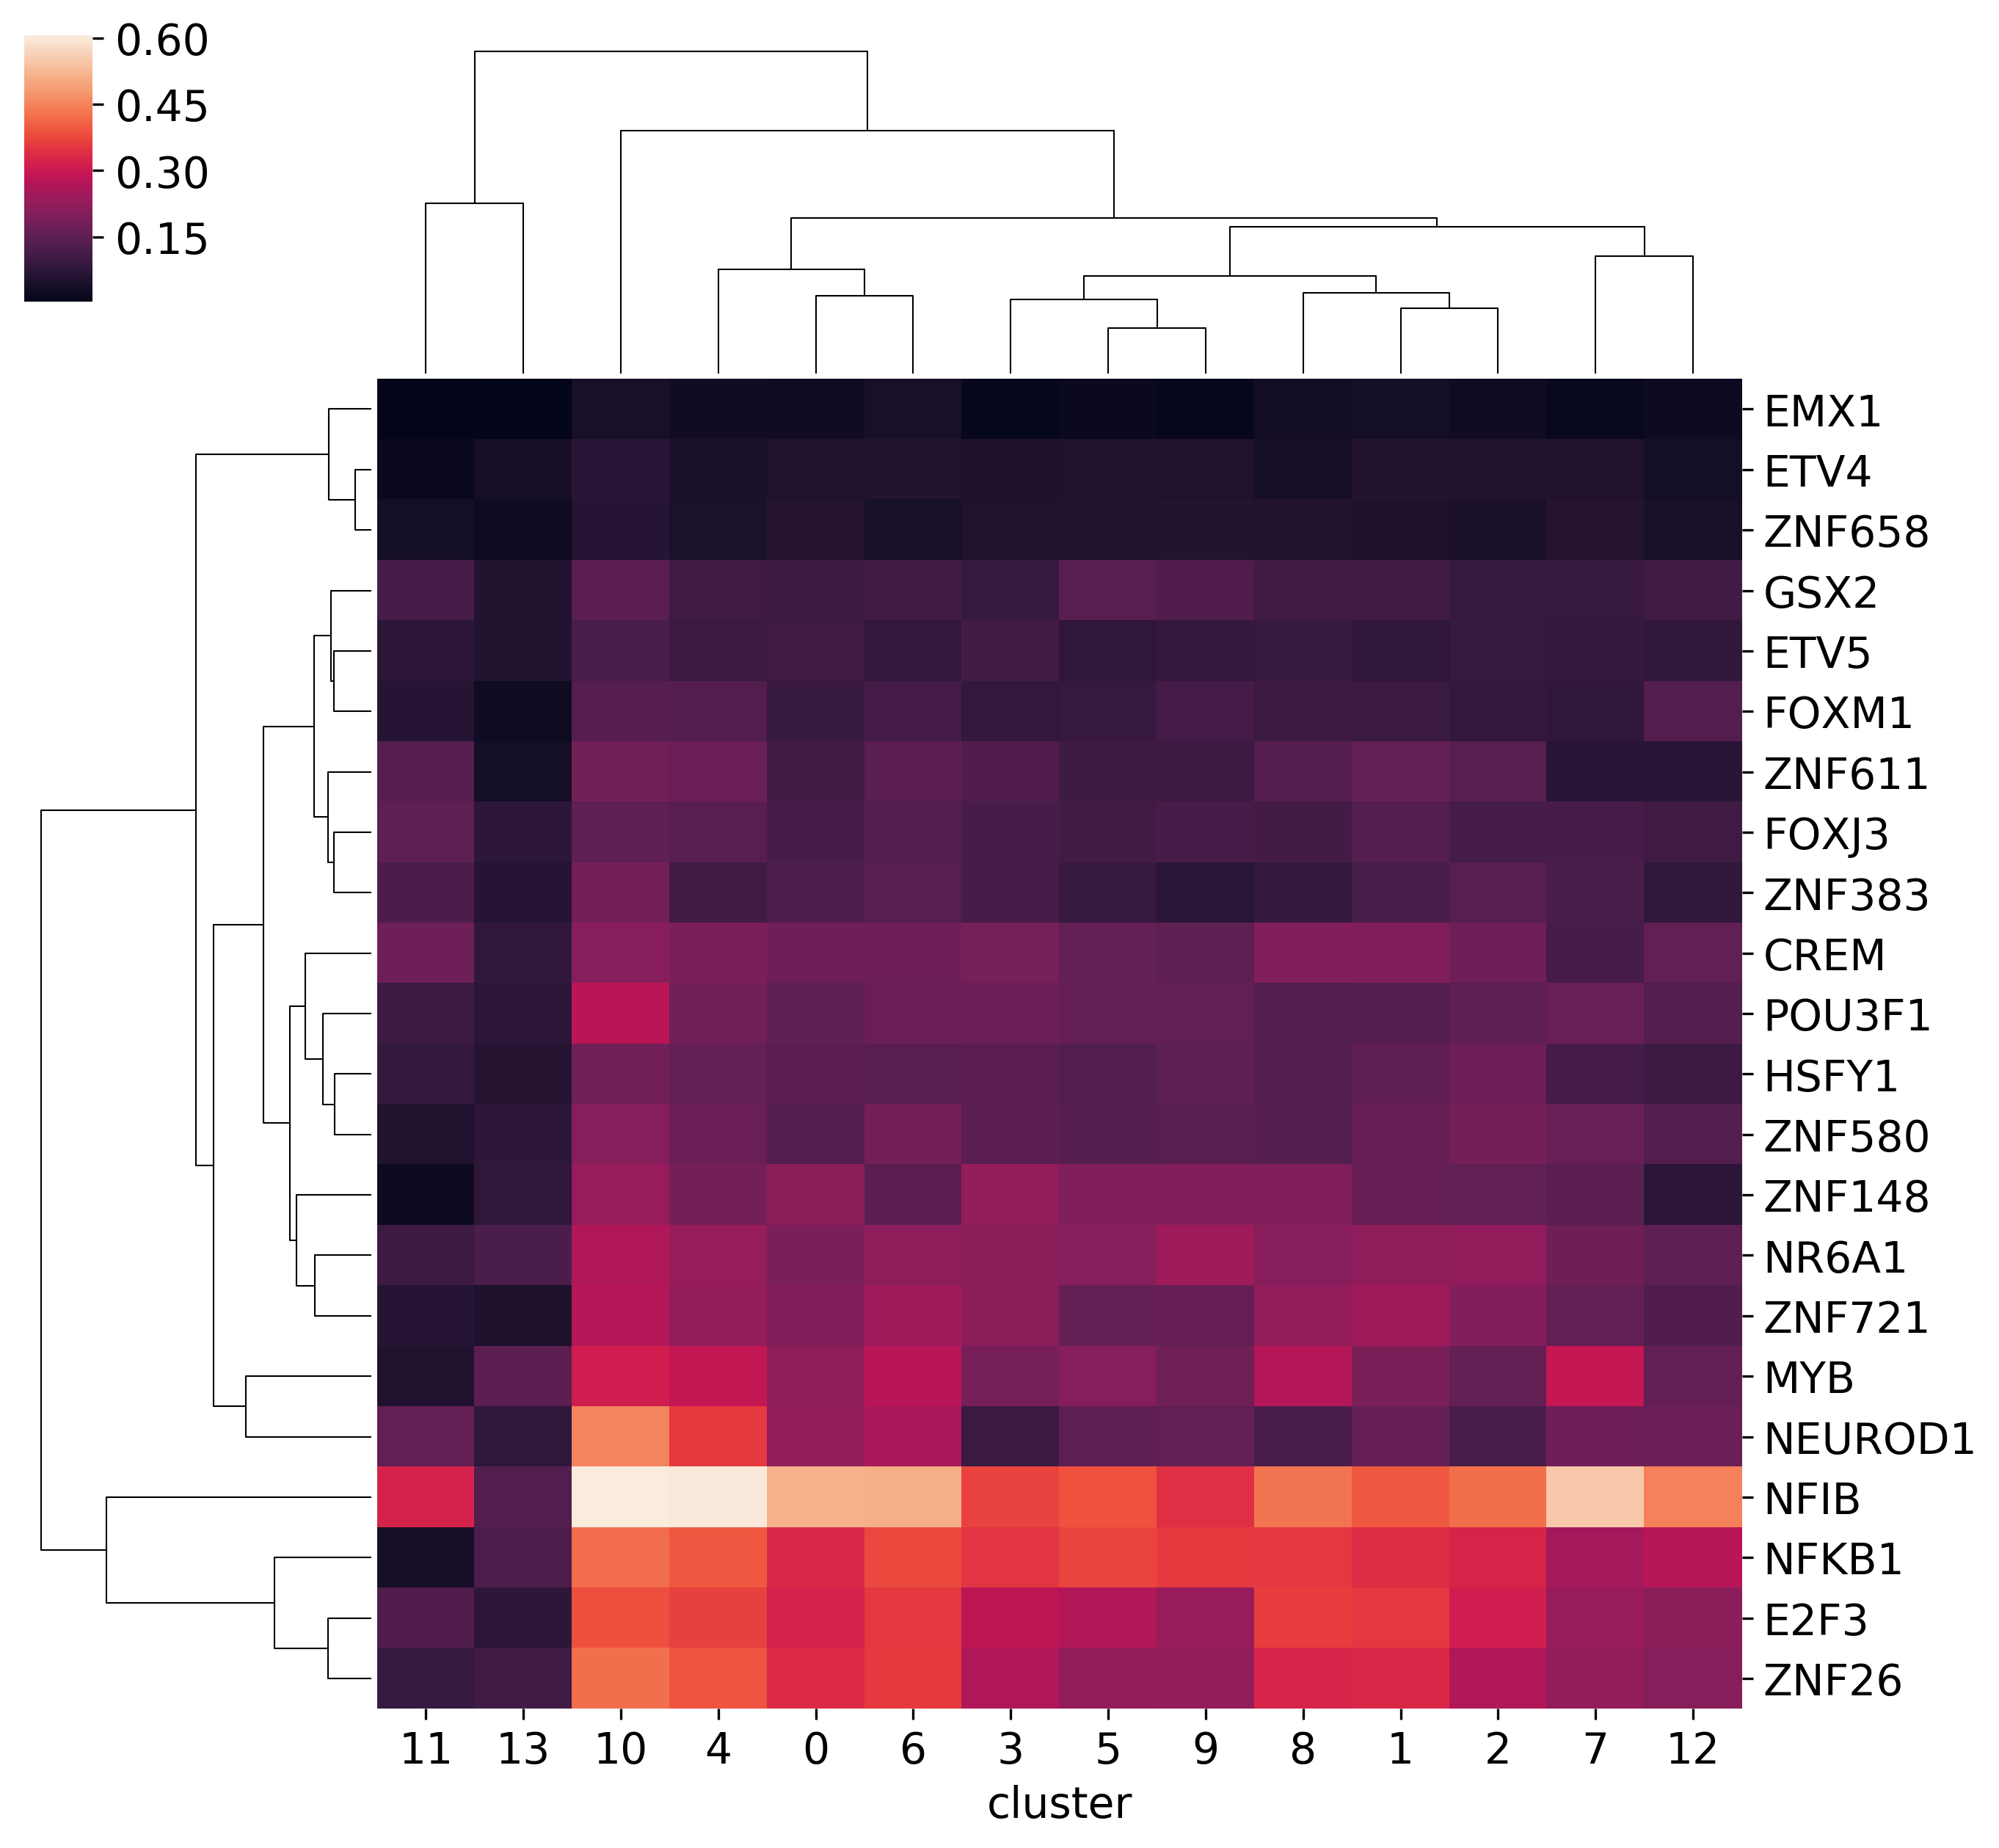

In [313]:
sns.clustermap(auc_avg[max_list].T)

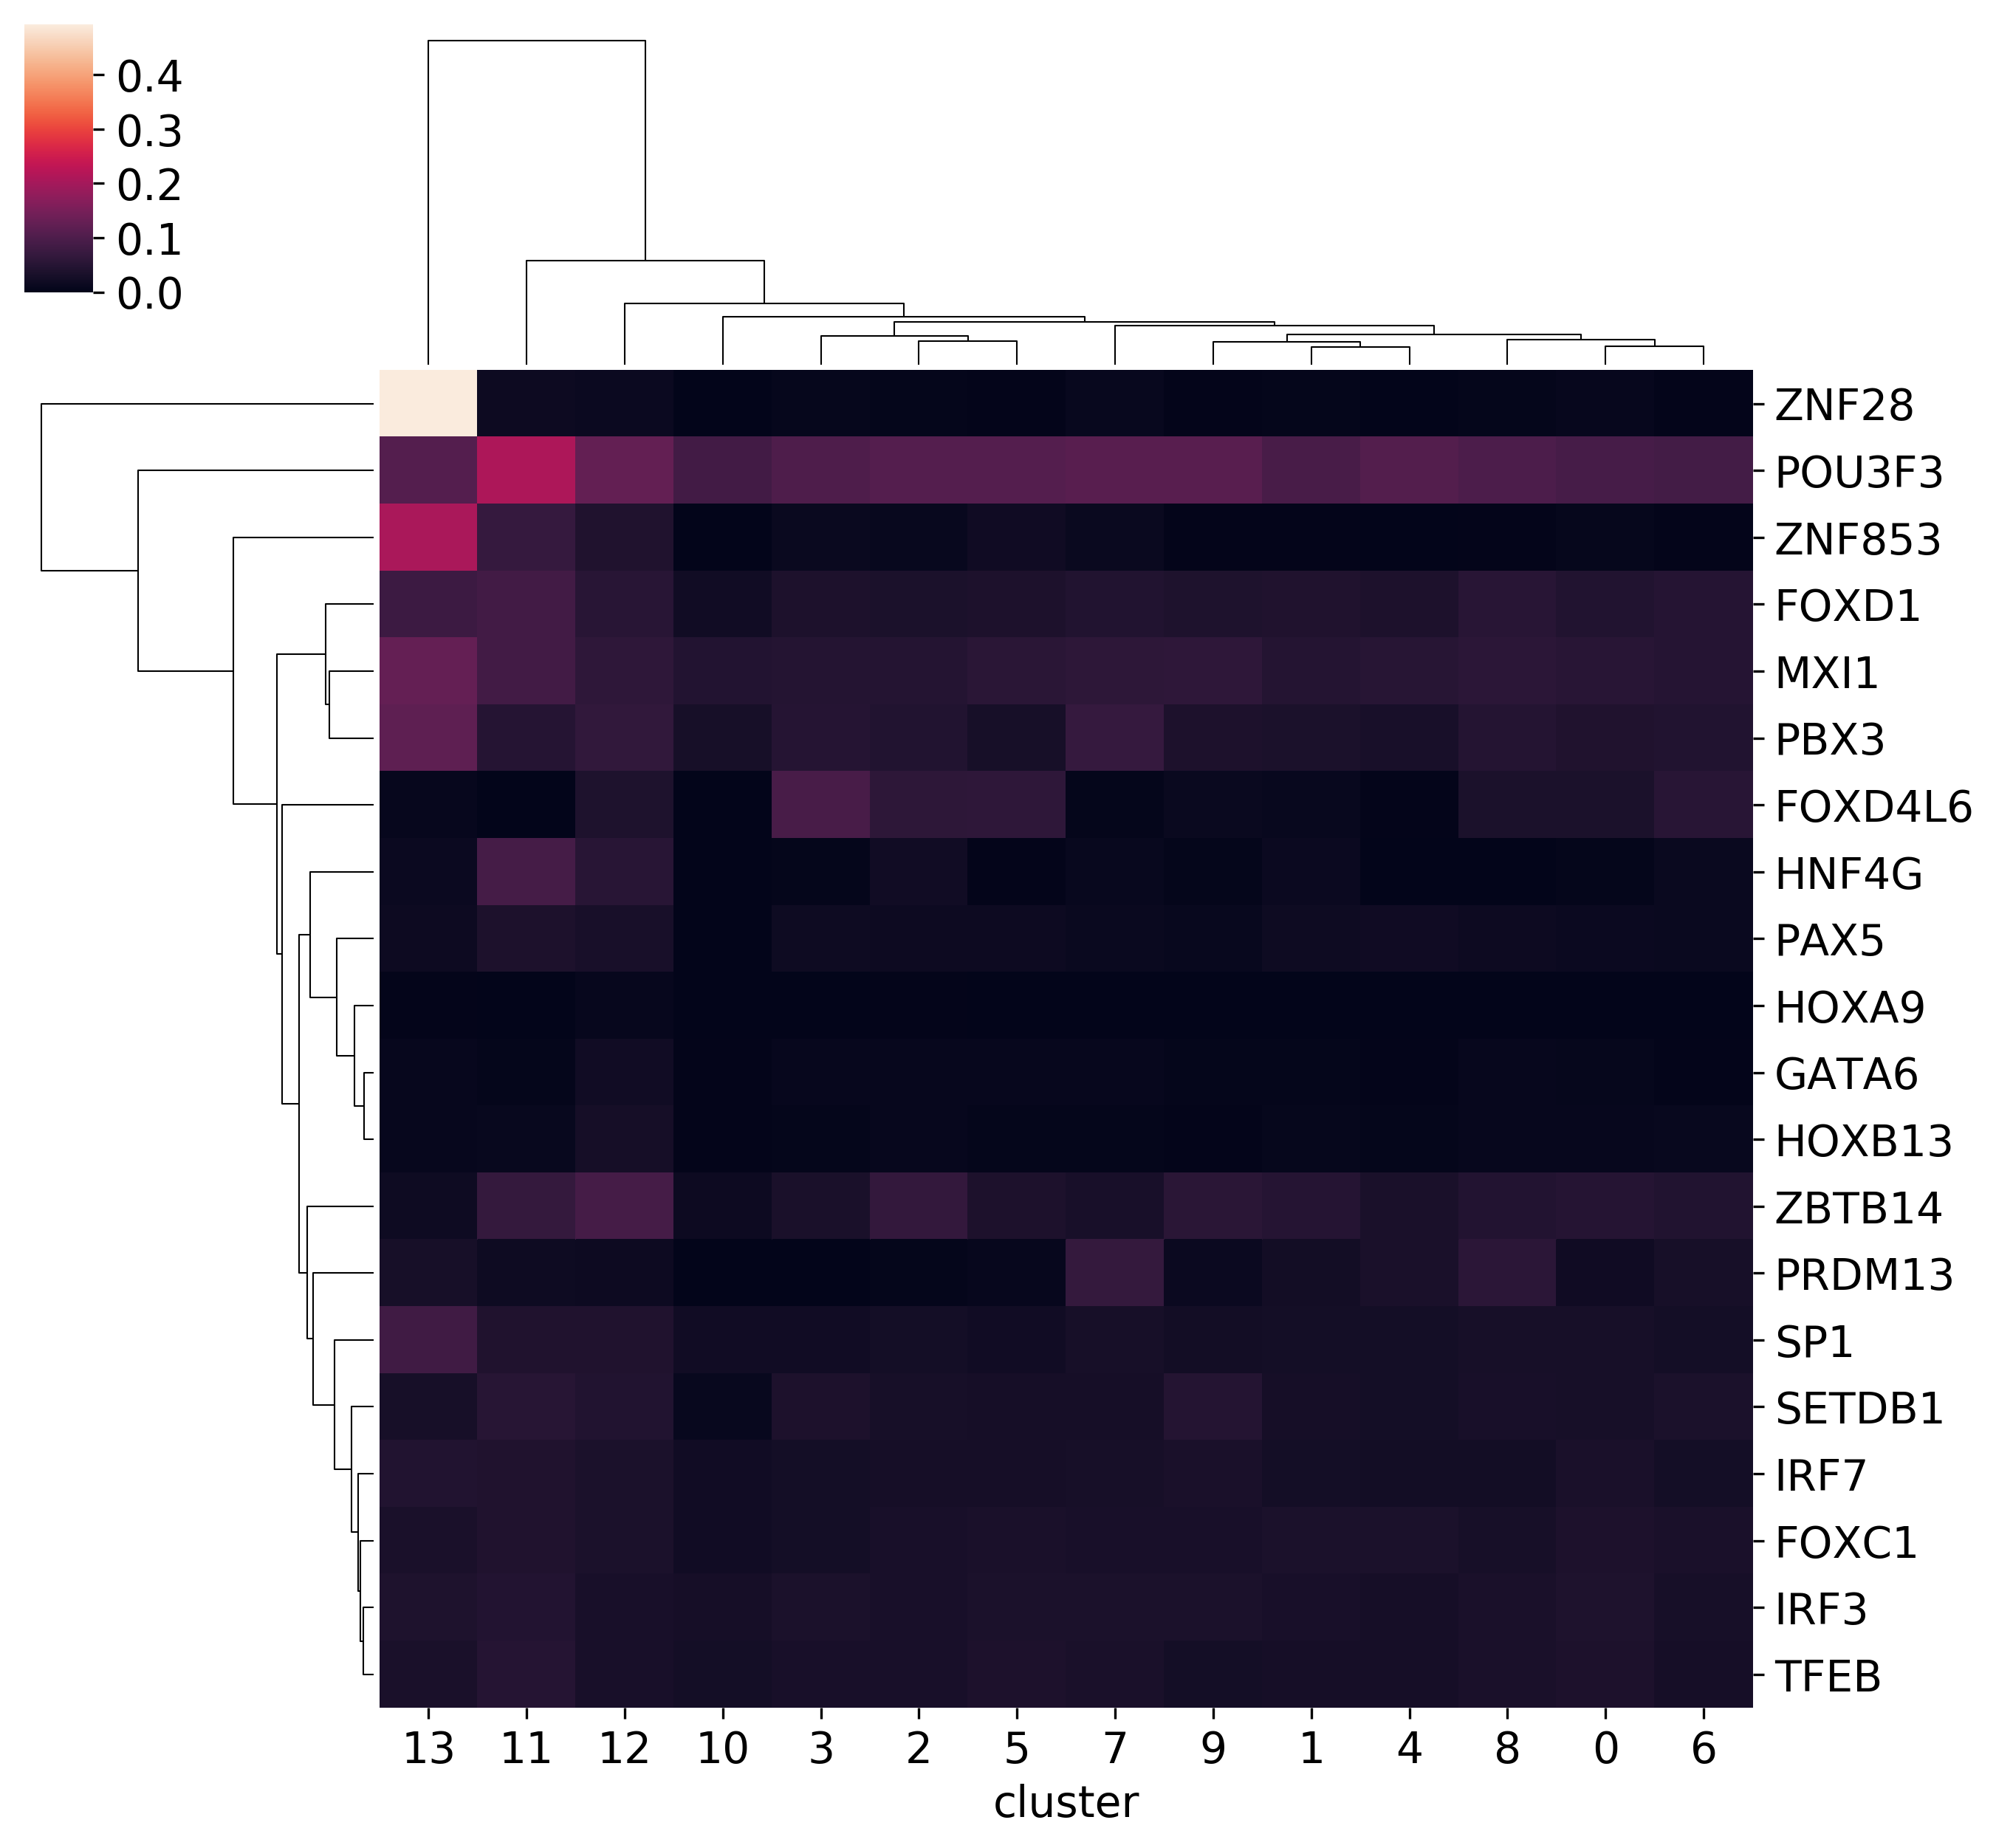

In [314]:
sns.clustermap(auc_avg[min_list].T)

In [325]:
grn_max = grn.loc[max_list]
grn_max = list(grn_max['Targets'])
grn_max = list(np.concatenate(grn_max))
grn_max = list(set(grn_max))
len(grn_max)

830

In [328]:
test = pd.DataFrame(grn_max)
test.to_csv(os.path.join(data_path, "test.csv"), sep="\t")